In [22]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
Looking in indexes: https://download.pytorch.org/whl/cu118


In [23]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
print("Cuda Available", torch.cuda.is_available())  # Should print True

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6
Cuda Available True


In [24]:
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
database_path = "/content/drive/My Drive/Colab Notebooks/Final Database"
train_annotations = os.path.join(database_path, "annotations", "instances_train.json")
val_annotations = os.path.join(database_path, "annotations", "instances_val.json")
train_images = os.path.join(database_path, "images", "train")
val_images = os.path.join(database_path, "images", "val")

In [27]:
register_coco_instances("bar_train", {}, train_annotations, train_images)
register_coco_instances("bar_val", {}, val_annotations, val_images)

In [28]:
dataset_dicts = DatasetCatalog.get("bar_train")
bar_metadata = MetadataCatalog.get("bar_train")

[01/11 12:14:09 d2.data.datasets.coco]: Loaded 28 images in COCO format from /content/drive/My Drive/Colab Notebooks/Final Database/annotations/instances_train.json


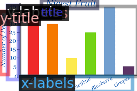

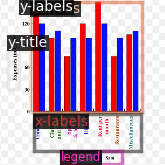

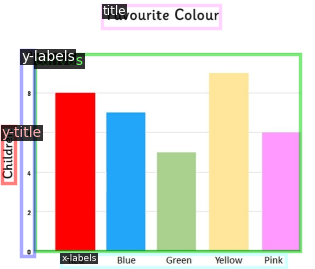

In [29]:
from google.colab.patches import cv2_imshow

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bar_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [30]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bar_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(bar_metadata.thing_classes)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/11 12:14:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/11 12:14:12 d2.engine.train_loop]: Starting training from iteration 0
[01/11 12:14:24 d2.utils.events]:  eta: 0:08:36  iter: 19  total_loss: 5.054  loss_cls: 2.062  loss_box_reg: 0.205  loss_rpn_cls: 2.321  loss_rpn_loc: 0.4158    time: 0.5541  last_time: 0.4817  data_time: 0.0631  last_data_time: 0.0059   lr: 4.9953e-06  max_mem: 2798M
[01/11 12:14:34 d2.utils.events]:  eta: 0:08:02  iter: 39  total_loss: 3.801  loss_cls: 1.86  loss_box_reg: 0.2596  loss_rpn_cls: 1.222  loss_rpn_loc: 0.4122    time: 0.5185  last_time: 0.5540  data_time: 0.0263  last_data_time: 0.0088   lr: 9.9902e-06  max_mem: 2798M
[01/11 12:14:44 d2.utils.events]:  eta: 0:07:50  iter: 59  total_loss: 2.658  loss_cls: 1.551  loss_box_reg: 0.3145  loss_rpn_cls: 0.3842  loss_rpn_loc: 0.3596    time: 0.5068  last_time: 0.5480  data_time: 0.0091  last_data_time: 0.0236   lr: 1.4985e-05  max_mem: 2799M
[01/11 12:14:54 d2.utils.events]:  eta: 0:07:39  iter: 79  total_loss: 2.013  loss_cls: 1.112  loss_box_reg: 0.3634  

In [31]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[01/11 12:23:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

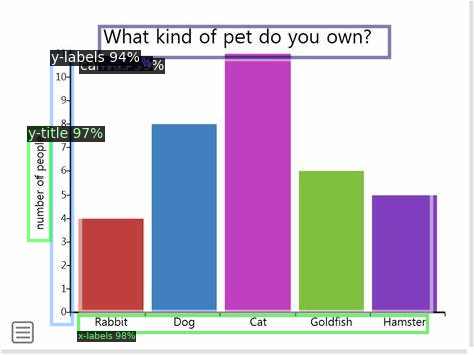

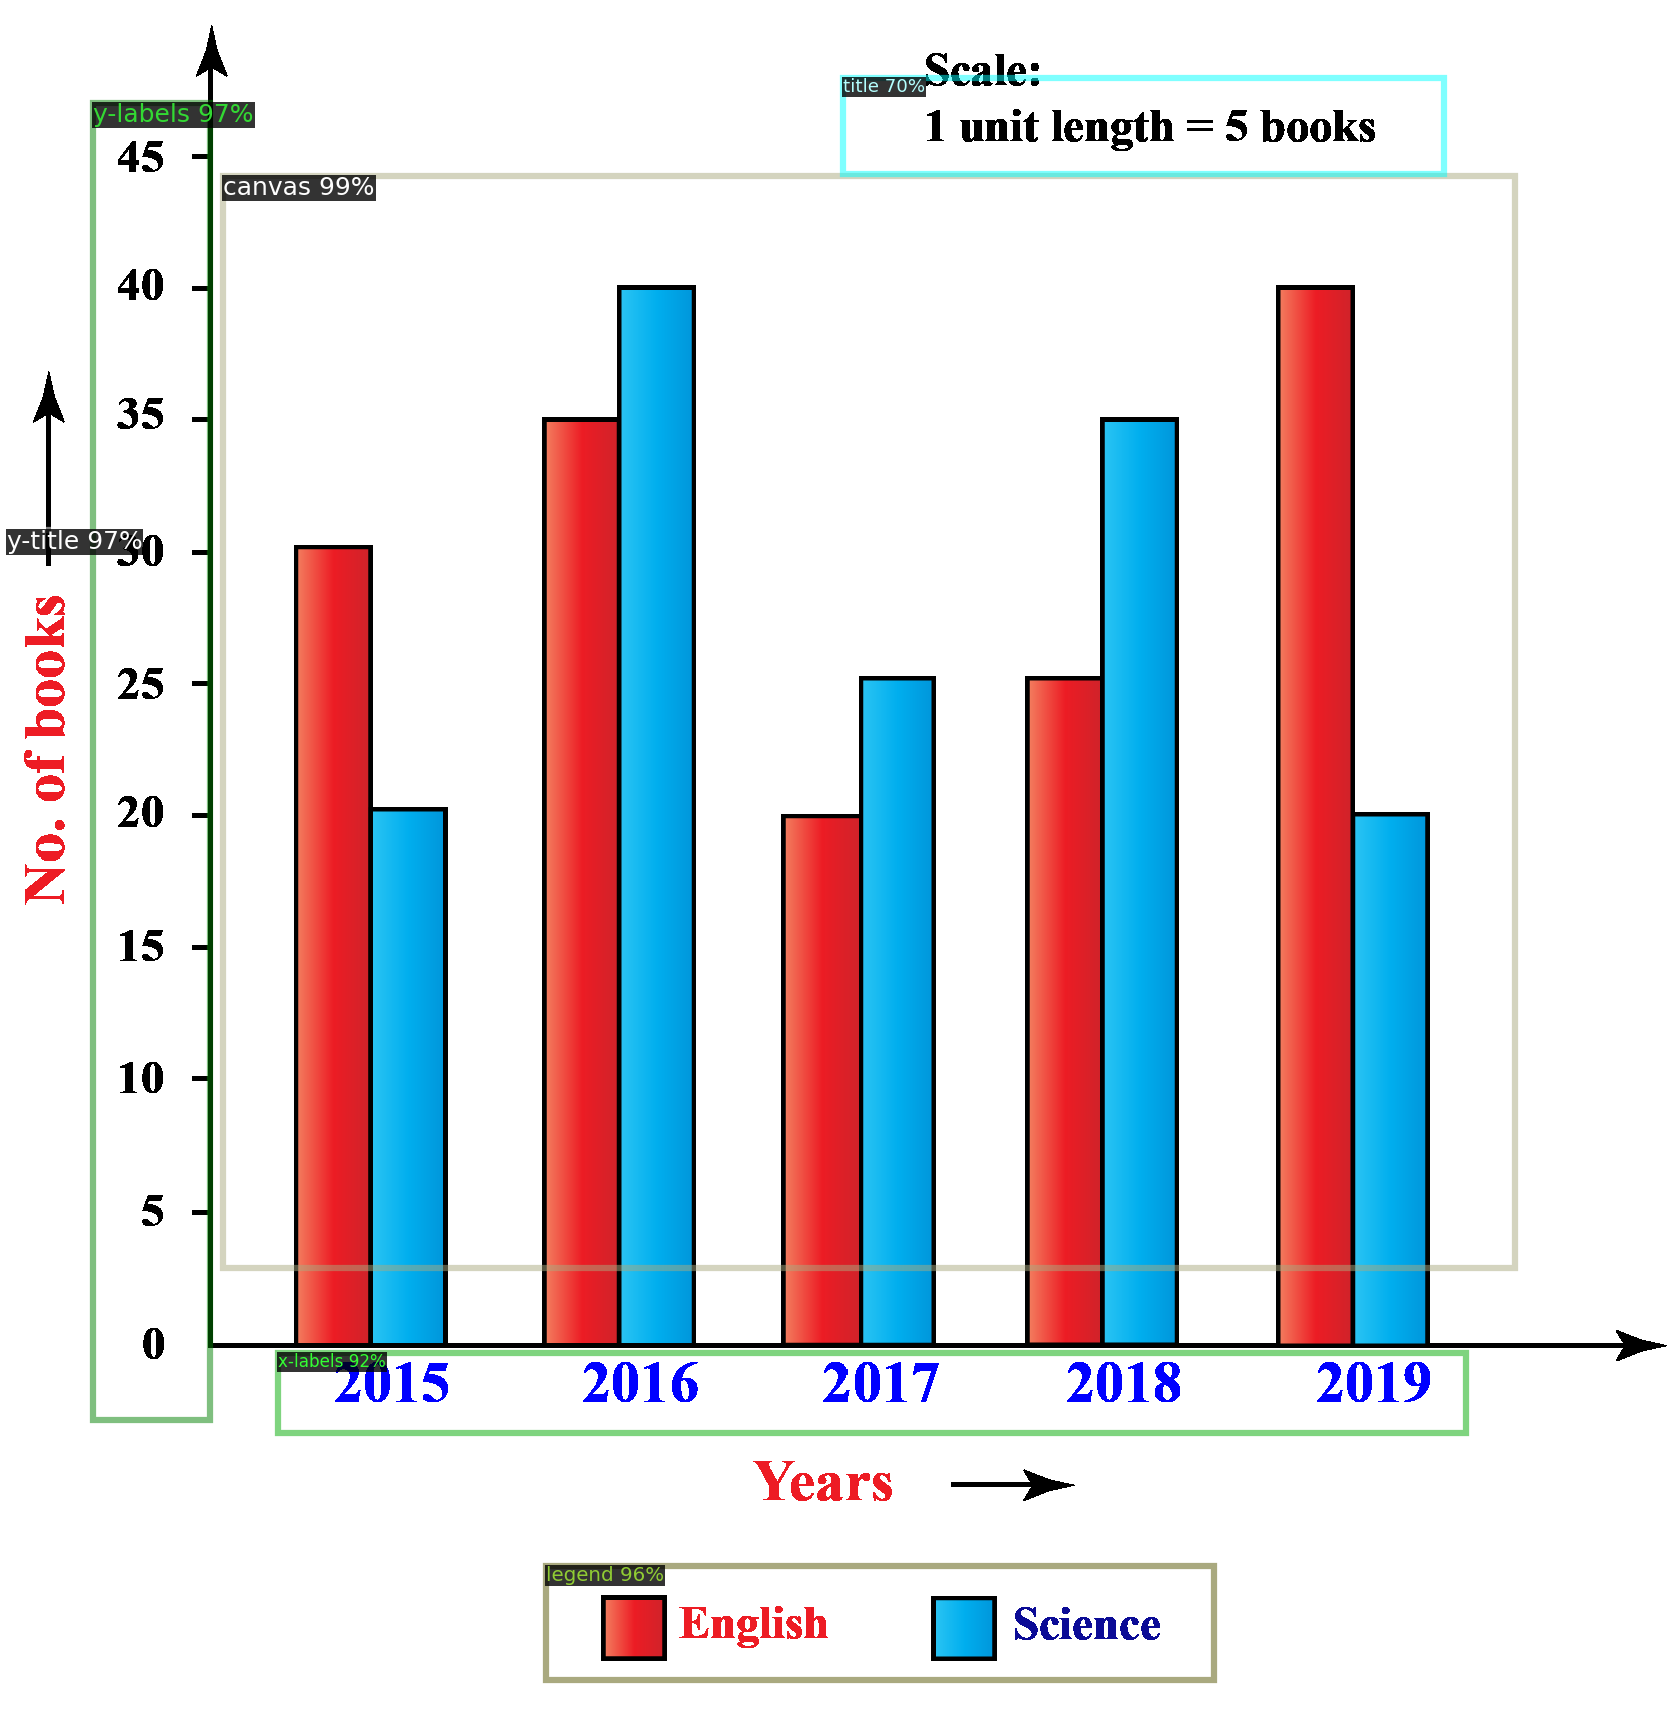

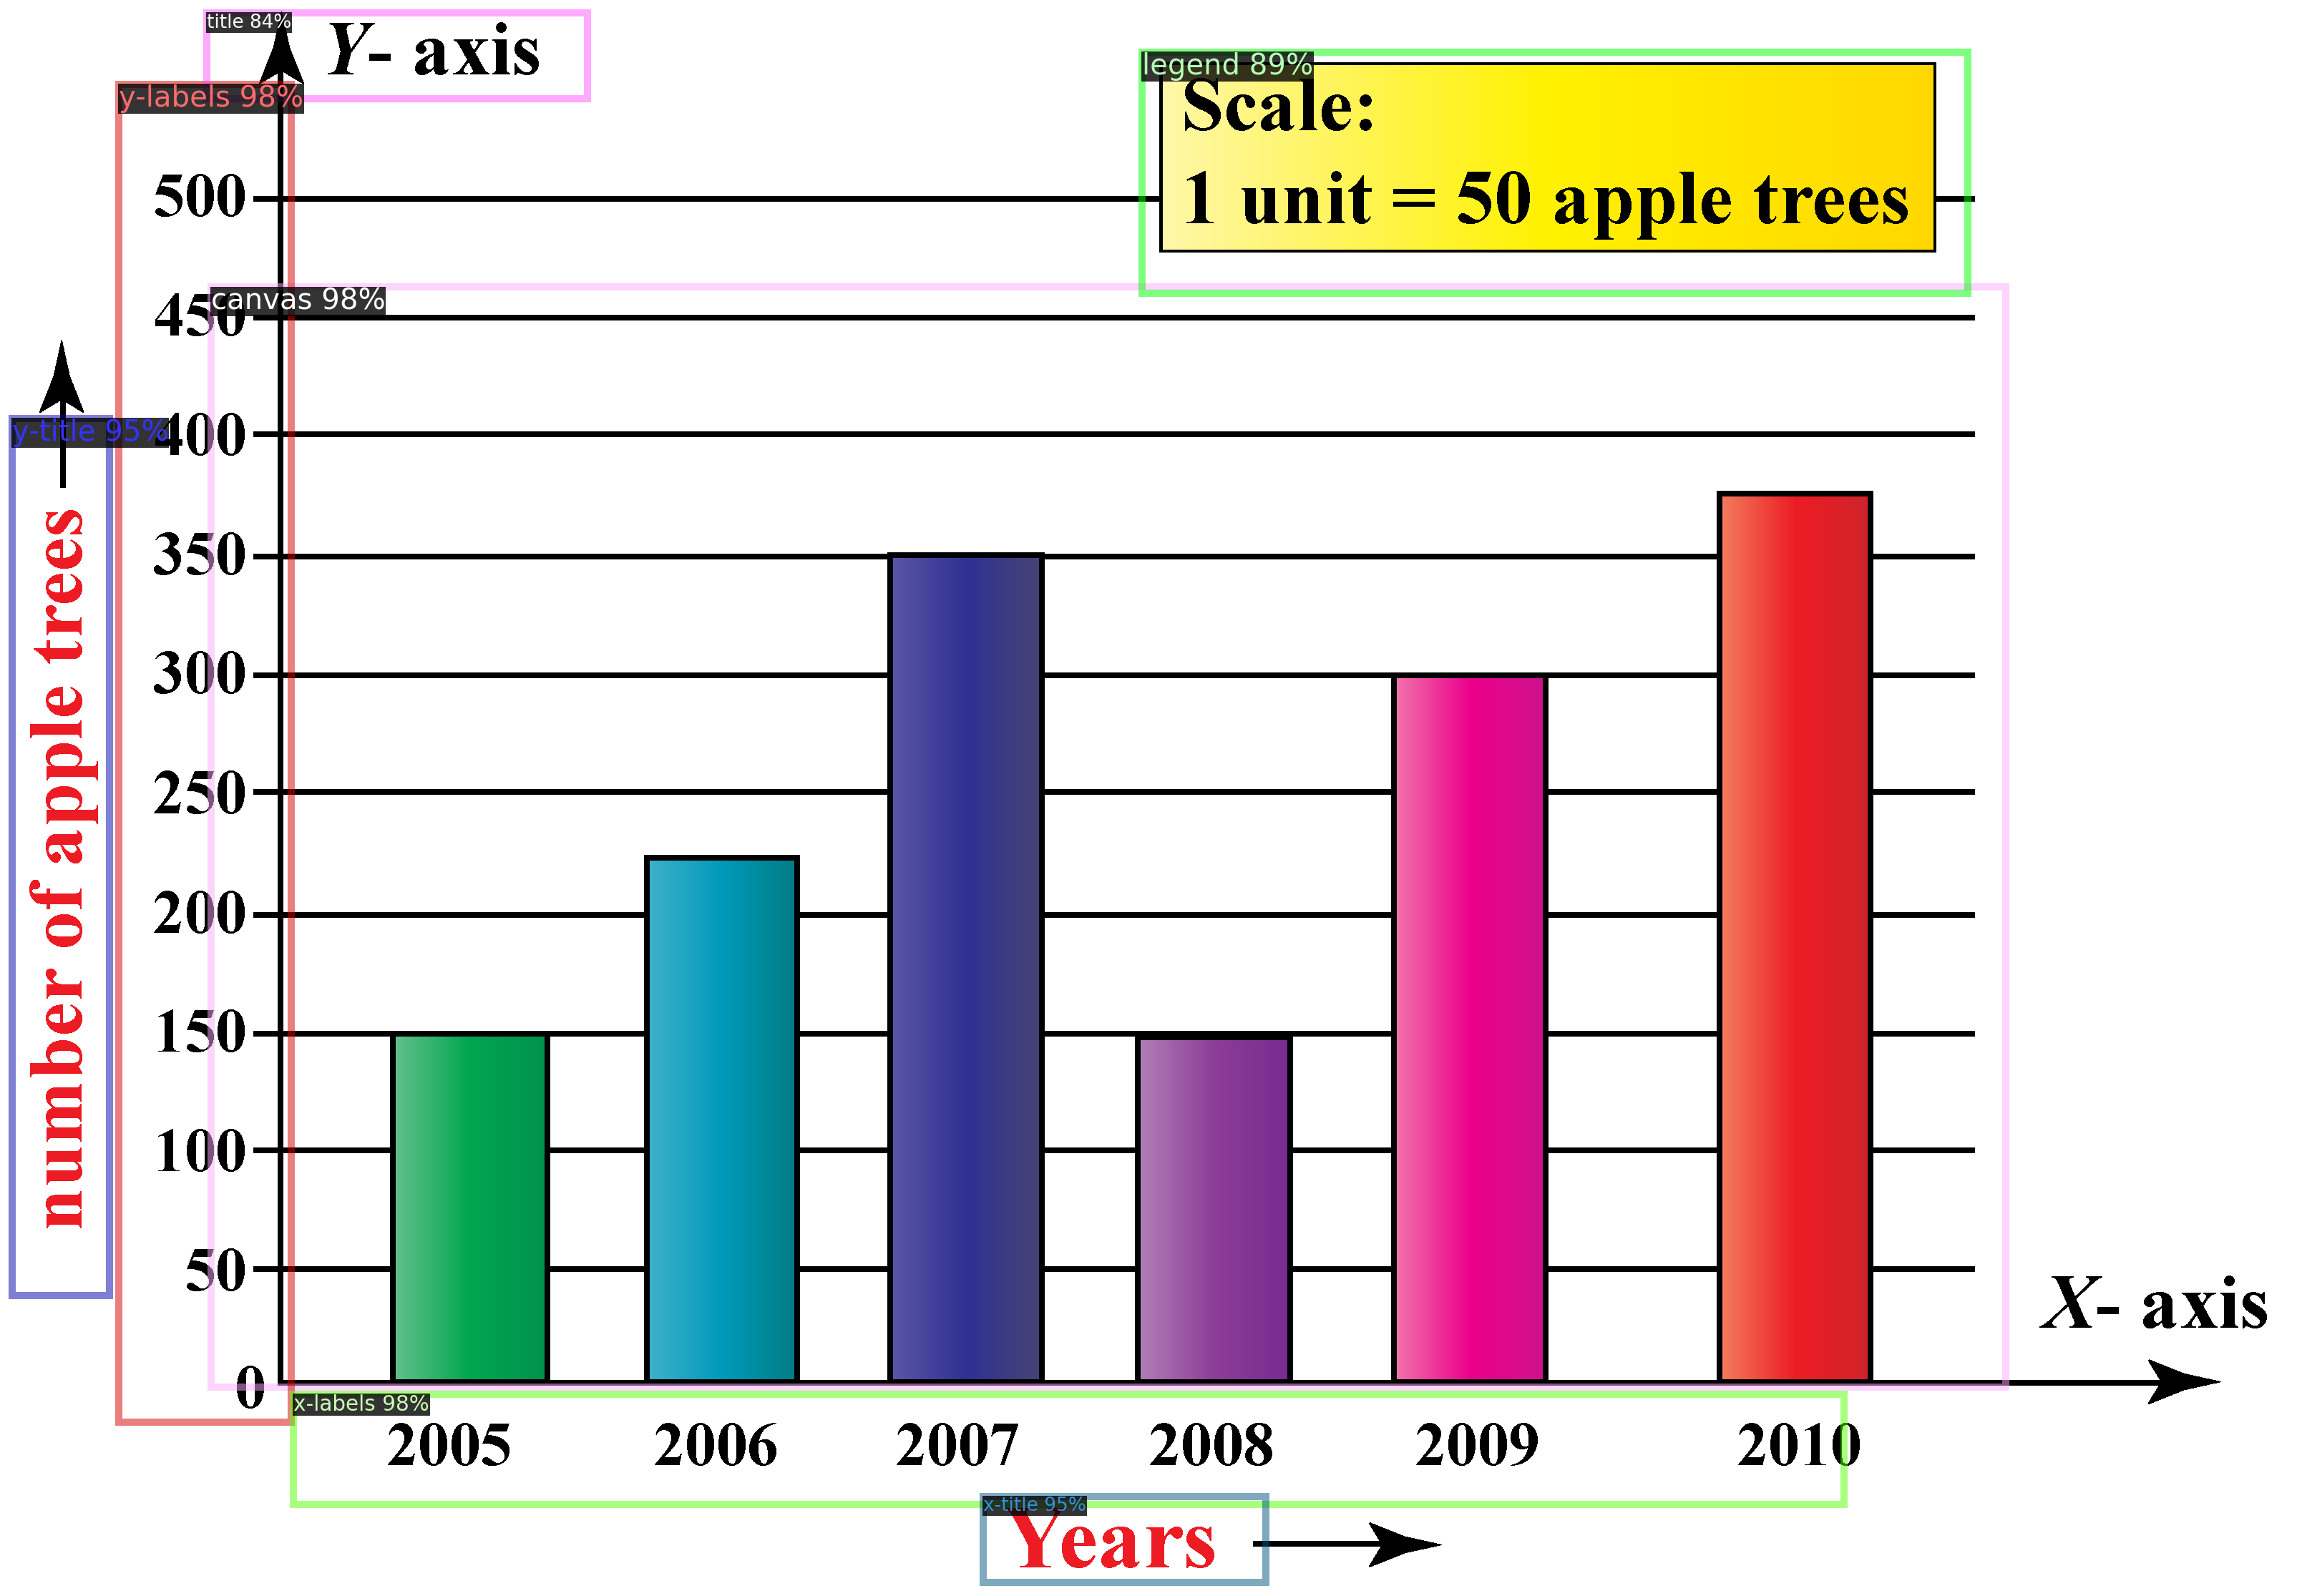

In [34]:
from detectron2.utils.visualizer import ColorMode

test_images_path = "/content/drive/My Drive/Colab Notebooks/Bar Database/images/test"

test_images = os.listdir(test_images_path)

# Randomly select 3 images
random_images = random.sample(test_images, 3)

# Loop through the selected images and visualize predictions
for image_name in random_images:
    image_path = os.path.join(test_images_path, image_name)

    im = cv2.imread(image_path)

    # Perform inference
    outputs = predictor(im)

    v = Visualizer(
        im[:, :, ::-1],
        metadata=bar_metadata,
        scale=1,
        instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    cv2_imshow(out.get_image()[:, :, ::-1])

In [33]:
torch.save(predictor.model.state_dict(), "model_weights.pth")